#Implementation of CAM (Class Activation Maps) GradCAM (Gradient-weighted Class Activation Maps)



### This is  inspired by the work done [here](https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82).

The goal is to visualize which parts of the input image contribute most to the model's decision for a specific class. These two approaches  differ in how they attribute importance to different regions of the input image.

* `CAM`:  uses the learned weight parameters of the final fully connected layer (classifier) to generate the activation map. The activation maps is obtained by doing a weighted combinations of the feature maps (Global Poolin Average).
* `GradCAM`:  takes advantage of the gradients of the predicted class with respect to the feature maps of a convolutional layer. The gradients provide information about how small changes in each pixel of the feature maps affect the final class score.








### Import some Libraries

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms

from torch.utils import data
from torchvision import datasets
from PIL import Image

## Helper funcion

In [30]:
def load_and_preprocess_image(image_path):
    '''
      This function Load and preprocess a given image path.
    '''

    img = cv2.imread(image_path)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    img = transforms.ToTensor()(img)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
    return img


def preprocess_image_before_plotting(image_path, use_rgb=True):
    img = cv2.imread(image_path)
    if use_rgb:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (300, 300))
    img = img.astype(np.float32) / 255.
    return img

### Upload the pre-trained model `Resnet-50`

In [5]:
resnet = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 292MB/s]


## Define the class **CAM**

In [6]:
class CAM(nn.Module):

    '''
    This class implement the cam approach to vizualize the salient parts of an image for a class prediction.

    '''

    def __init__(self, model):
        super(CAM, self).__init__()

        self.resnet = model

        # Access the last convolutional layer of the model
        self.features_conv = nn.Sequential(*list(self.resnet.children())[:-2])

        # Get the classifier of the model
        self.classifier = self.resnet.fc

    def forward(self, x):
        x = self.features_conv(x)

        x = x.view(x.size(0),-1, x.size(1))

        x = self.classifier(x)
        return x


### Set the image path and execute the class

In [27]:
image_path = '/content/cat_dog.jpeg'

In [31]:
model = CAM(resnet)
model.eval()

# Perform the forward pass
img_tensor = load_and_preprocess_image(image_path)
img_tensor = img_tensor.unsqueeze(0)
output = model(img_tensor)

# Get the weight (parameters) of the final fully connected layer
class_weights = model.classifier.weight.data

# Get the feature maps from the last convolutional layer
feature_maps = model.features_conv(img_tensor)

# Calculate the class activation map (CAM)
cam = torch.matmul(class_weights, feature_maps.view(feature_maps.size(0), feature_maps.size(1), -1))
cam = cam.view(cam.size(0), -1, feature_maps.size(2), feature_maps.size(3))
cam = torch.sum(cam, dim=1, keepdim=True)

# Normalize the CAM
cam = (cam - cam.min()) / (cam.max() - cam.min())


# Convert the CAM to a numpy array for visualization
cam = cam.squeeze().detach().numpy()
cam = np.maximum(cam, 0)

In [32]:
# Load the image and preprocess as needed
img = preprocess_image_before_plotting(image_path)

# Resize and preprocess the heatmap
heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))

heatmap = cv2.merge([heatmap, heatmap, heatmap])
heatmap = cv2.normalize(heatmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

heatmap = (heatmap * 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


# Blend the heatmap with the original image
alpha = 0.5
heatmap = np.float32(heatmap) / 255
superimposed_img = (1 - alpha) * heatmap + alpha * img

### Display the original image & the associated CAM

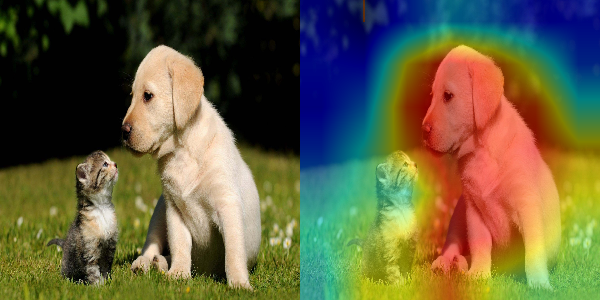

In [33]:
images = np.hstack((np.uint8(255*img), np.uint8(255*superimposed_img)))
Image.fromarray(images)

## Define the class **GradCAM**



In [34]:
class GradCAM(nn.Module):
    '''
    This class implement the grad-cam approach to vizualize the salient parts of an image for a class prediction.
    Some methods:
    - register_hook() is call  on a tensor x (representing an image) and provide  with the
    function activations_hook() that we want to execute when gradients are computed for x.
    - get_activations_gradient()  returns the stored gradients when needed.

    '''


    def __init__(self,model):
        super(GradCAM, self).__init__()

        self.resnet = model

        # Access the last convolutional layer of the model
        self.features_conv = nn.Sequential(*list(self.resnet.children())[:-2])

        # get the classifier of the model
        self.classifier = self.resnet.fc

        # Global Average Pooling (GAP) layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.gradients = None

    # custom function that will be executed when gradients are computed
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features_conv(x)

        # register the hook
        h = x.register_hook(self.activations_hook)

        x = self.global_avg_pool(x)
        x = x.squeeze()
        x = self.classifier(x)
        return x

    # method to extract the gradient
    def get_activations_gradient(self):
        return self.gradients

    # method to get the last layer of the resnet
    def get_activations(self, x):
        return self.features_conv(x)


In [35]:
model = GradCAM(resnet)
model.eval()

img_tensor = load_and_preprocess_image(image_path)
pred = model(img_tensor.unsqueeze(0))

# get the gradient of the output with respect to the parameters of the model
idx = pred.argmax(dim=0)
pred[idx].backward()

# pull the gradients out of the model
gradients = model.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0,2,3])

# get the activations of the last convolutional layer
activations = model.get_activations(img_tensor.unsqueeze(0)).detach()


# weight the channels by corresponding gradients
for i in range(activations.size(1)):
    activations[:,i, :, :] *= pooled_gradients[i]

# average the channels of the activations
grad_cam = torch.mean(activations, dim=1).squeeze()


# draw the heatmap
# grad_cam = np.maximum(grad_cam, 0)
grad_cam /= torch.max(grad_cam)
grad_cam = grad_cam.detach().numpy()


In [36]:
# Load the image and preprocess as needed
img = preprocess_image_before_plotting(image_path)

# Resize and preprocess the heatmap
heatmap = cv2.resize(grad_cam, (img.shape[1], img.shape[0]))

heatmap = cv2.merge([heatmap, heatmap, heatmap])
heatmap = cv2.normalize(heatmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

heatmap = (heatmap * 255).astype(np.uint8)
heatmap = cv2.applyColorMap(heatmap[:,:,0], cv2.COLORMAP_JET)

# Blend the heatmap with the original image
alpha = 0.5
heatmap = np.float32(heatmap) / 255.
superimposed_img = (1 - alpha) * heatmap + alpha * img

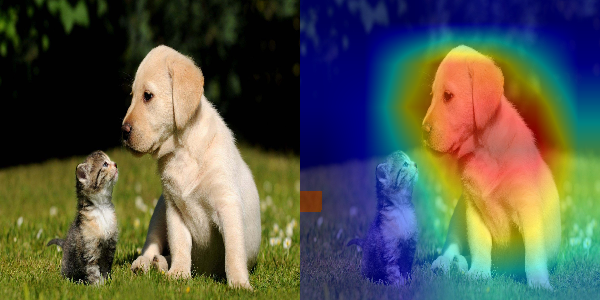

In [37]:
images = np.hstack((np.uint8(255*img), np.uint8(255*superimposed_img)))
Image.fromarray(images)

## Comment:
As observed from the plots, in comparison to the CAM method, the GradCAM approach highlights a more specific region of the image that the network considered when assigning the class '(kuvasz)' to the image.

#Implementation of GradCAM using **pytorch_grad_cam** library

In [ ]:
!pip install grad-cam

In [39]:
from pytorch_grad_cam import GradCAM,GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image

In [43]:
# use the pretrained ResNet50 model
model = resnet
model.eval()

targets = [ClassifierOutputTarget(222)]

# fix the target layer
target_layers = [model.layer4]

In [45]:
# instantiate the model
cam = GradCAM(model=model, target_layers=target_layers)

# Preprocess input image, get the input image tensor
img = np.array(Image.open(image_path))
img = cv2.resize(img, (224,224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img)

# generate CAM
grayscale_cams = cam(input_tensor=input_tensor, targets=targets)

cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)

cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])

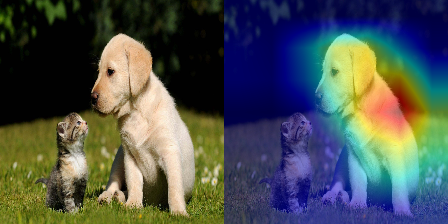

In [46]:
# display the original image & the associated CAM
images = np.hstack((np.uint8(255*img), cam_image))
Image.fromarray(images)